In [6]:
# importation des packages
import pandas as pd
import numpy as np
from sklearn import svm, linear_model, datasets, metrics
# import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve, auc
import operator
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

ImportError: No module named xgboost

In [3]:
class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])
                    ])

        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
        return self
    
def mape(a, b):
    mask = a != 0
    return ((abs(a-b)/a)[mask].mean())

In [232]:
#Importation des tables
base = pd.read_csv('./base_tot_finale.csv', sep = ';')

In [233]:
base = base[np.isfinite(base['D.total'])]
base = base.drop(['TS.adm', 'TS.med'], axis = 1) 
base = base[base['tri.iao']!=1]

In [234]:
base = base.drop(['min_adm', 'annee', 'jour_mois'], axis = 1 )

In [235]:
X = base.drop('D.total', axis = 1)
Y = base['D.total']
X['tri.iao'] = X['tri.iao'].apply(str)

In [236]:
#OneHotEncoding pour le XGboost
X_sparse = pd.get_dummies(X, dummy_na=True) 

In [237]:
# On sépare notre base 'train' (celle où on a les labels à disposition) en trois différentes bases : 
# Train : 60pct
# Test 20 pct
# Validation 20 pct

X_train, X_inter, y_train, y_inter = train_test_split(X_sparse, Y, test_size=0.4, random_state=123)
X_test, X_validation, y_test, y_validation = train_test_split(X_inter, y_inter, test_size=0.5, random_state=42)

X_train_glm, X_inter_glm, y_train_glm, y_inter_glm = train_test_split(X, Y, test_size=0.4, random_state=123)
X_test_glm, X_validation_glm, y_test_glm, y_validation_glm = train_test_split(X_inter_glm, y_inter_glm, test_size=0.5, random_state=42)

In [177]:
# On cherche l'eta et la profondeur max optimaux pour notre XGB en faisait de la Cross-Validation
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import StratifiedKFold

gbm = xgb.XGBRegressor()
gbm_params = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'max_depth': [3, 4, 6, 8, 10],
    'min_child_weight' : [1, 10, 50]
}
grid = GridSearchCV(gbm, gbm_params,verbose=1,n_jobs=-1)
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


KeyboardInterrupt: 

In [238]:
# On effectue notre XGBOOST avec eta = 0.1 et max depth = 10 car meilleurs valeurs d'après la CV d'avant
# On prend merror comme eval_metric car multiclass

params = {
    'objective': 'reg:linear',
    'min_child_weight': 50,
    'eta': 0.1,
    'max_depth': 4,
    'verbose_eval': True,
    'nthread':8,
    'eval_metric':'mae',
    'colsample_bytree' : 0.8,
    'subsample' : 0.8
}
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgvalidation = xgb.DMatrix(X_validation, label=y_validation)
xgtest = xgb.DMatrix(X_test)
watchlist = [ (xgtrain,'train'), (xgvalidation,'validation')]
model = xgb.train(params, xgtrain, 1000, watchlist, early_stopping_rounds=200, verbose_eval =False)

y_train_xgb = model.predict(xgtrain)
y_test_xgb = model.predict(xgtest)
validation = model.predict(xgvalidation)

In [239]:
mape(y_test_xgb, y_test)

0.58647922639393546

In [259]:
#Précision de notre modèle : 
metrics.mean_absolute_error(y_test_xgb, y_test)

28.571469839732227

In [241]:
## On veut afficher l'importance des variables du XGboost
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

In [242]:
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

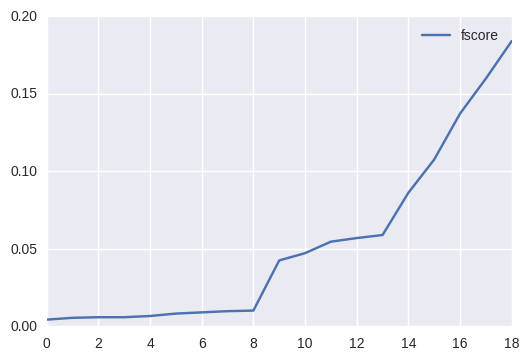

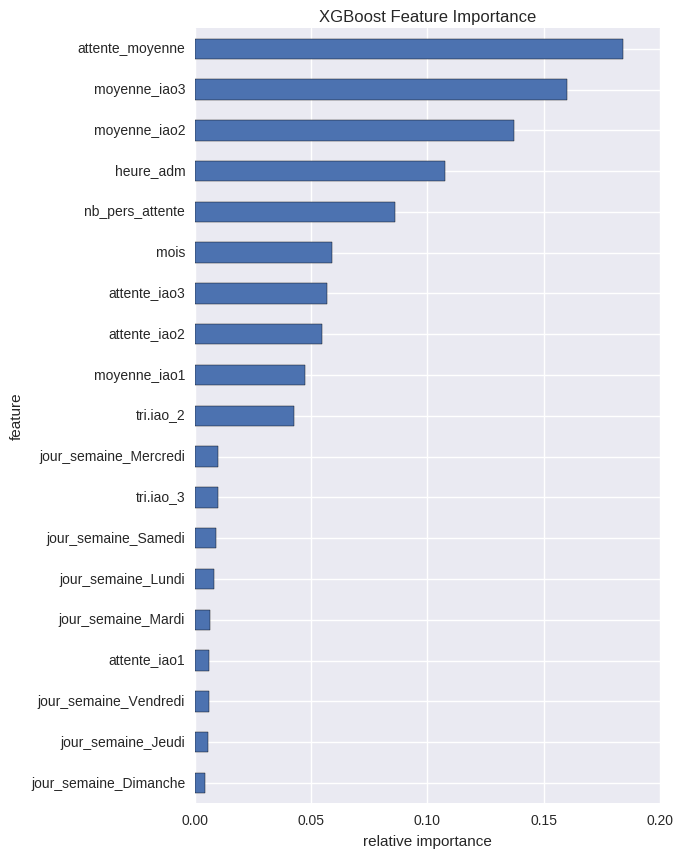

In [243]:
plt.figure()
df.iloc[-40:].plot()
df.iloc[-40:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [15]:
base_glm = base
base_glm['tri.iao'] = base['tri.iao'].apply(str)
base_glm['mois'] = base['mois'].apply(str)
base_glm['tri.iao'] = base['tri.iao'].apply(str)
base_glm['annee'] = base['annee'].apply(str)
base_glm['heure_adm'] = base['heure_adm'].apply(str)

In [220]:
X = base_glm[['tri.iao', 'nb_pers_attente', 'jour_mois', 'mois', 'annee']]
Y = base_glm['D.total']

In [221]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [222]:
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((regr.predict(X) - Y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X, Y))

Coefficients: 
 [  2.25086273e+01   5.29676909e+00  -1.34478596e-02  -7.81627681e-01
  -6.86731809e+00]
Mean squared error: 1973.38
Variance score: 0.14


In [223]:
pd.DataFrame(list(zip(X.columns, regr.coef_)), columns = ['Variables', 'Coefficients'])

,Variables,Coefficients
0,tri.iao,22.508627
1,nb_pers_attente,5.296769
2,jour_mois,-0.013448
3,mois,-0.781628
4,annee,-6.867318


In [225]:
X_train_glm = X_train_glm.drop('jour_semaine', axis = 1)
X_test_glm = X_test_glm.drop('jour_semaine', axis = 1)

In [226]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train_glm)
est = sm.GLM(y_train_glm, X2)
est2 = est.fit()
print(est2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                D.total   No. Observations:                41020
Model:                            GLM   Df Residuals:                    41012
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                   1961.13396009
Method:                          IRLS   Log-Likelihood:            -2.1369e+05
Date:                Wed, 12 Apr 2017   Deviance:                   8.0430e+07
Time:                        16:39:48   Pearson chi2:                 8.04e+07
No. Iterations:                     4                                         
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const            1.511e+04    944.886     15.988      0.000      1.33e+04   1.7e+04
tri.iao            23.6183      0.469

In [227]:
pred_glm = est2.predict(sm.add_constant(X_test_glm))
pred_moyenne = np.repeat(y_train_glm.mean(), len(y_test_glm), axis=0)
#Précision de notre modèle : 
metrics.mean_absolute_error(pred_moyenne, y_test_glm)

33.189784605768722

In [230]:
metrics.mean_absolute_error(pred_glm, y_test_glm)


30.187257685218071

In [233]:
metrics.mean_absolute_error(pred_moyenne, pred_moyenne + 30)

30.000000000000004